### Market Basket Analysis
---

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import janitor
from plotnine import *
import mizani.formatters as miz
import pandas_flavor as pf
import spacy
import pickle

from spacy.attrs import IS_ALPHA
from spacy.matcher import Matcher
import nltk
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

# nltk.download('stopwords')
COLOR = {"light_blue": "#d0e2ff", "dark_blue": "#0f62fe"}

In [3]:
# read dataset and select only the relevant columns for our analysis
retail_df = pd.read_csv('Online_Retail.csv', encoding="ISO-8859-5")\
    .clean_names(case_type='snake')[['invoice_no', 'description', 'invoice_date']]\
    .to_datetime('invoice_date')

In [4]:
# view the first two dataframe
retail_df.head(10)

,invoice_no,description,invoice_date
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00
1,536365,WHITE METAL LANTERN,2010-12-01 08:26:00
2,536365,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00
5,536365,SET 7 BABUSHKA NESTING BOXES,2010-12-01 08:26:00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,2010-12-01 08:26:00
7,536366,HAND WARMER UNION JACK,2010-12-01 08:28:00
8,536366,HAND WARMER RED POLKA DOT,2010-12-01 08:28:00
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2010-12-01 08:34:00


In [5]:
# check total transactions of our dataset
retail_df.invoice_no.nunique()

25900

In [6]:
# temporal start date
retail_df.invoice_date.min()

Timestamp('2010-12-01 08:26:00')

In [7]:
# temporal end date
retail_df.invoice_date.max()

Timestamp('2011-12-09 12:50:00')

In [8]:
# temporal duration
retail_df.invoice_date.max() - retail_df.invoice_date.min()

Timedelta('373 days 04:24:00')

In [35]:
# count unique items in transactions
retail_df.description.nunique()

4018

#### Drop missing data

In [26]:
retail_df = retail_df.dropna()

#### Common Purchased Items

In [10]:
item_description = retail_df.description.str.upper().to_list()

In [11]:
def get_lemma(description: list) -> list:
    
    global COLOR
    
    # preprocess item description
    nlp = spacy.load('en_core_web_sm')
    matcher = Matcher(nlp.vocab)
    stop_words = set(stopwords.words('english'))
    
    # create pattern
    pattern = [{'IS_ALPHA': True}]
    matcher.add('ONLY_STR_ITEM', [pattern])

    lemma = []
    for doc in tqdm(
            nlp.pipe(item_description, disable=["tagger", "parser"]),
            desc='Preprocessing text',
            colour=COLOR['dark_blue'],
        ):
        
        # check for matches in matcher (only use non-digit docs)
            matches = matcher(doc)
            for match_id, start, end in matches:
                
                # get doc content
                span = doc[start:end]
        
                # check if text is not included in stop words
                if span not in stop_words:
                    lemma.append(span)
                
    return lemma

In [12]:
# get lemmatized of item description
# description_lemmatized = get_lemma(item_description)

# convert description to str to pickle
# item_description_lemmatized = [str(i) for i in description_lemmatized]

In [13]:
# with open('lemmatized_item_description.pickle', 'wb') as p:
#     pickle.dump(item_description_lemmatized, p)

In [14]:
with open('lemmatized_item_description.pickle', 'rb') as p:
    item_description_lemmatized = pickle.load(p)

In [15]:
# get the top 100 item word counts
item_word_counts = pd.Series(item_description_lemmatized).value_counts()[:100]

# change series to dataframe and rename cols
item_word_df: pd.DataFrame = item_word_counts\
    .to_frame()\
    .reset_index()\
    .rename_columns({'index': 'item_word'})

In [16]:
# get the item word values to use as 
item_word_list = item_word_df.item_word.to_list()

In [17]:
word_count_bar = ggplot(item_word_df, aes(x='item_word', y='count'))\
    + geom_col(fill=COLOR['light_blue'], color=COLOR['dark_blue'], width=.5)\
    + scale_x_discrete(name="Item word", limits=item_word_list)\
    + scale_y_continuous(labels=miz.comma_format(), expand=(0, 0, 0.1, 0))\
    + theme(
        figure_size=(12, 6),
        axis_title_x=element_text(size=8),
        axis_title_y=element_text(size=8),
        axis_text_x=element_text(angle=90, size=7),
        axis_text_y=element_text(size=7)
    )

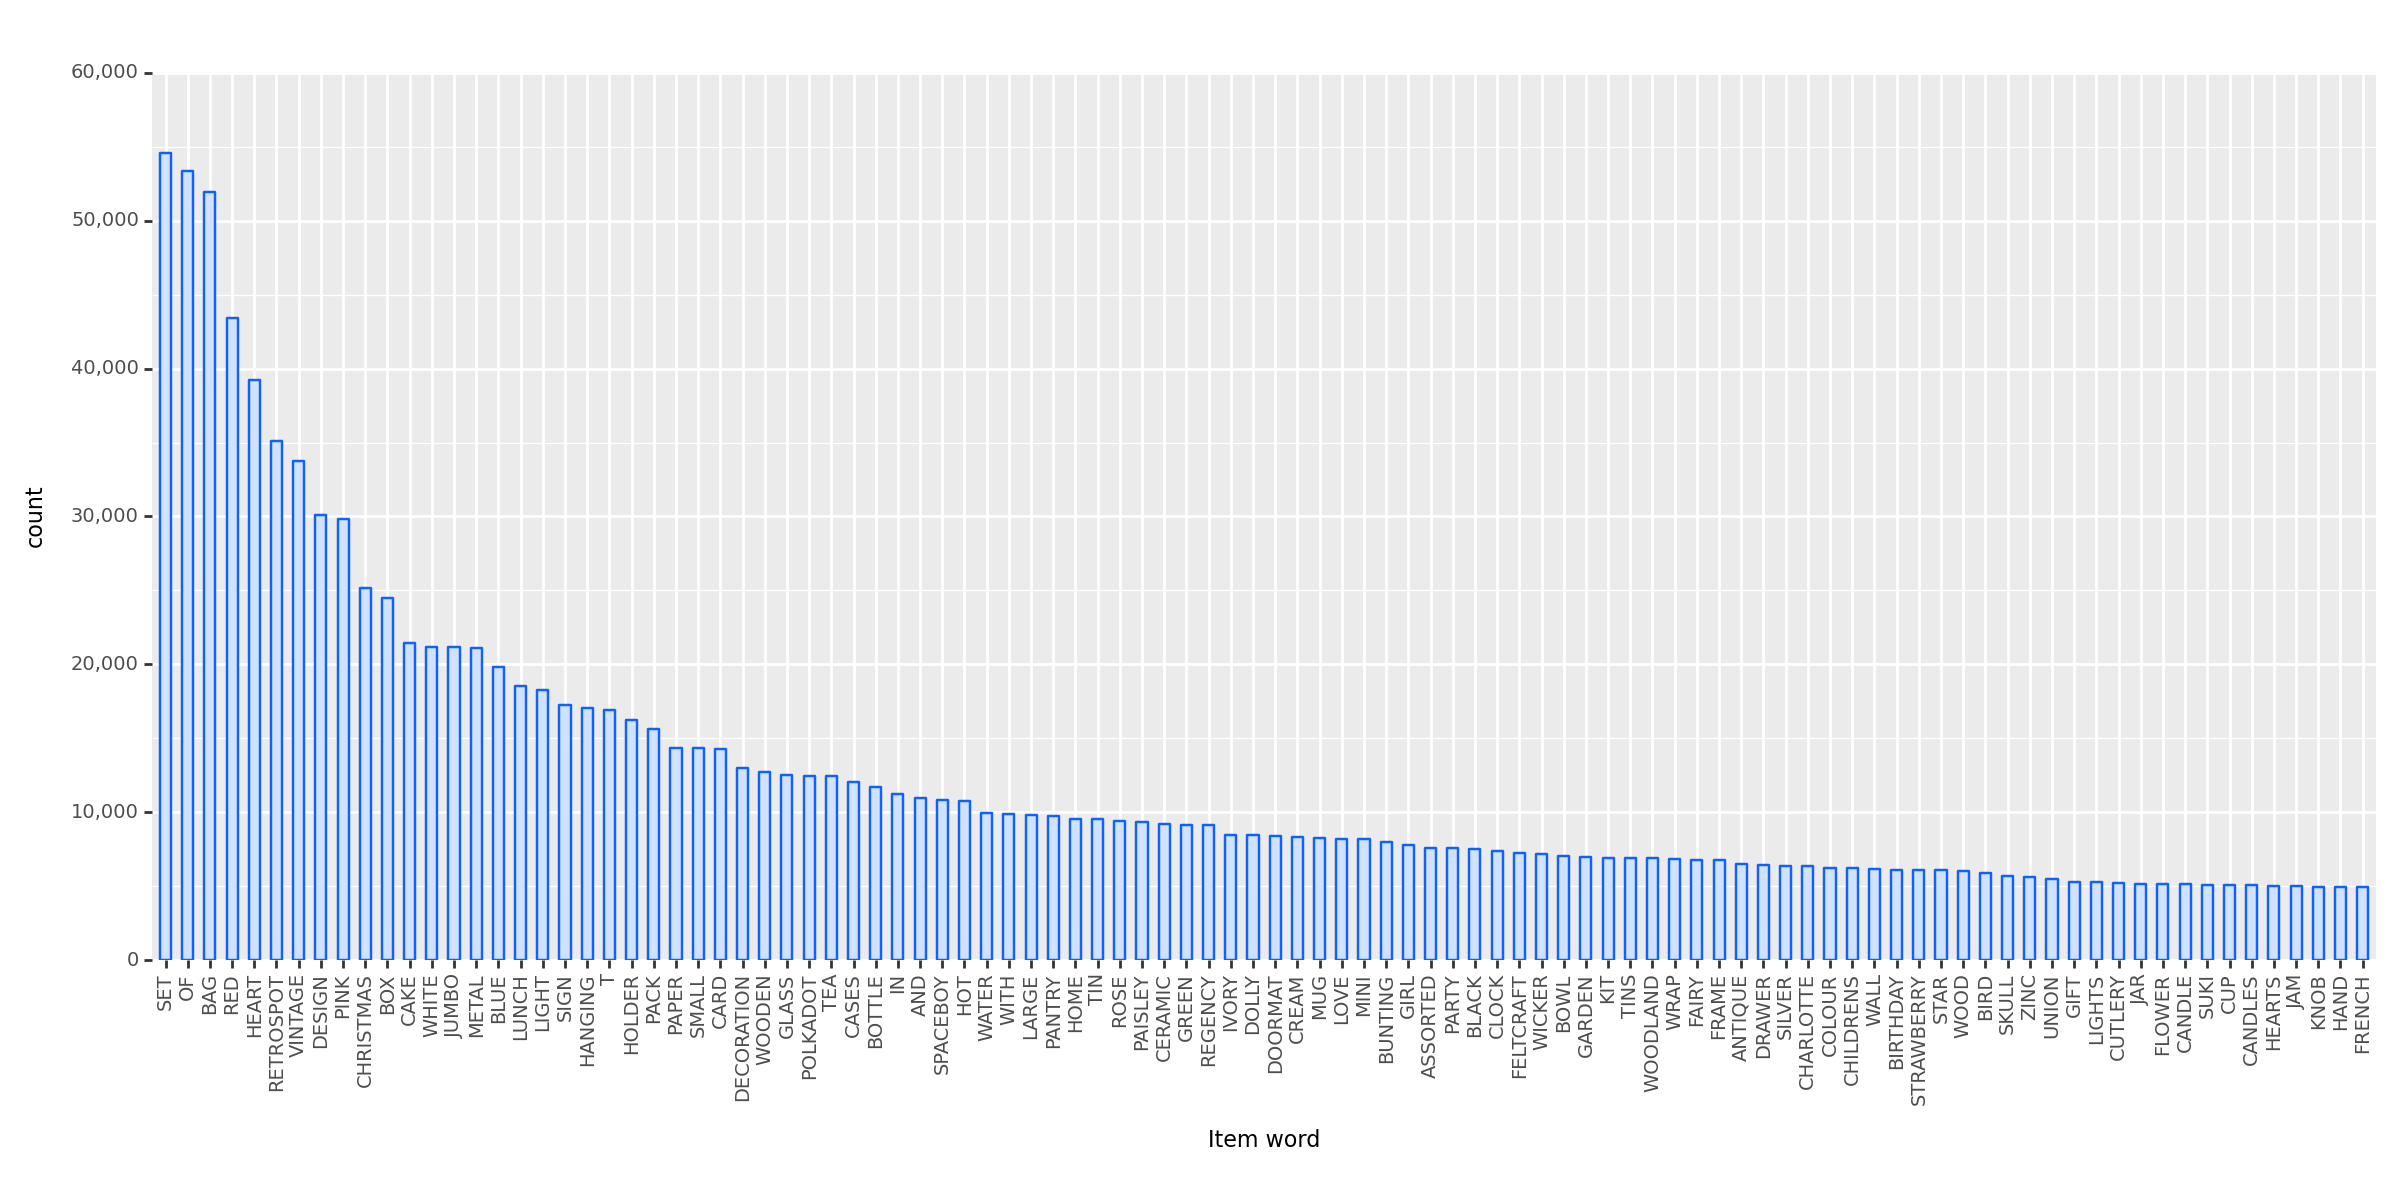

In [18]:
word_count_bar.draw()

#### No. of transactions from Start to End 

In [19]:
# create counts dataframe of total transactions per day
retail_df['invoice_date_1'] = retail_df.invoice_date.dt.strftime('%Y-%m-%d')
transactions_count_df = retail_df\
    .groupby(['invoice_date_1'])\
    .count()['invoice_no']\
    .reset_index(name='counts')\
    .to_datetime('invoice_date_1')

In [20]:
transaction_line = ggplot(transactions_count_df, aes(x='invoice_date_1', y='counts'))\
    + geom_line()\
    + geom_area(fill=COLOR['light_blue'], color=COLOR['dark_blue'])\
    + scale_x_date(name="Invoice Date", expand=(0, 0), date_labels="%b")\
    + scale_y_continuous(labels=miz.comma_format(), expand=(0, 0, 0.1, 0))\
    + theme(
        figure_size=(9, 4), 
        axis_title_x=element_text(size=7),
        axis_title_y=element_text(size=7),
        axis_text_x=element_text(size=7),
        axis_text_y=element_text(size=7),
    )

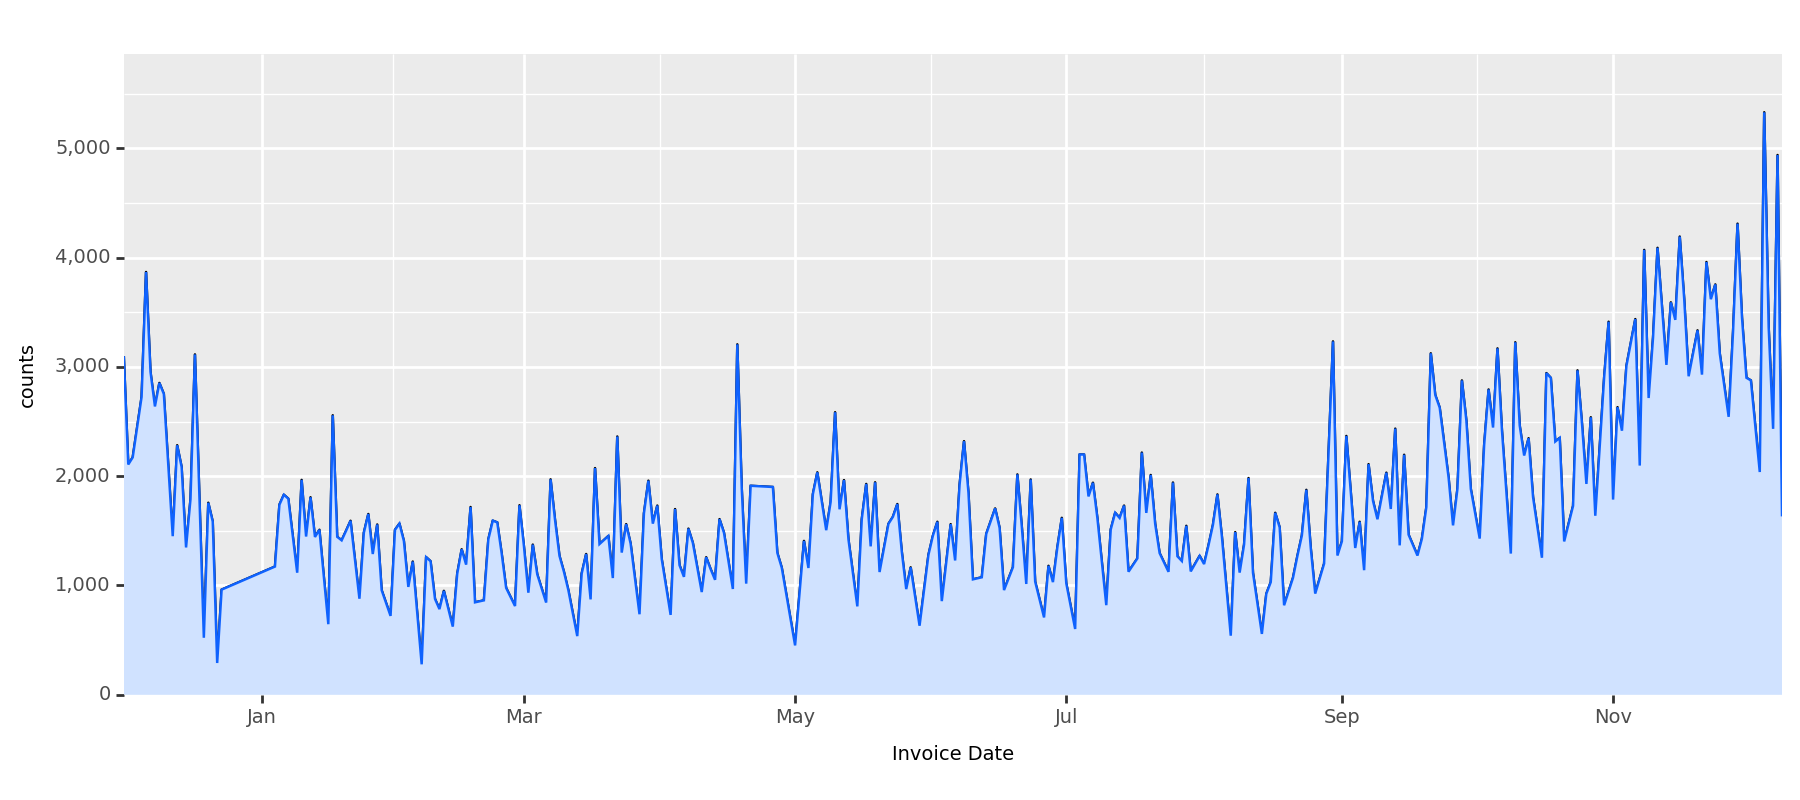

In [21]:
transaction_line.draw()

#### Preprocessing Item Description

In [22]:
# to do so we can check for lowercase entries in our item description and assign them as null values
def get_lower_case_entries(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Maps the column and assert if entry is in lowercase. If so then it will be assign
    as null.
    """
    try:
        return df[col].apply(lambda x: x if x.isupper() else np.nan)
    except AttributeError:
        print(f"column '{col}' contains non-str type data entry.")

In [23]:
# description contains comments and missing entries which we need to clean before proceeding
retail_df[retail_df.description.str.contains('missing')]

,invoice_no,description,invoice_date,invoice_date_1
218477,556046,missing,2011-06-08 12:56:00,2011-06-08
323469,565310,?missing,2011-09-02 12:26:00,2011-09-02
324024,565385,?missing,2011-09-02 15:46:00,2011-09-02
418129,572701,missing,2011-10-25 14:31:00,2011-10-25
464813,576185,missing?,2011-11-14 11:25:00,2011-11-14
493686,578245,?? missing,2011-11-23 12:37:00,2011-11-23
497819,578476,????missing,2011-11-24 12:45:00,2011-11-24
497820,578477,???missing,2011-11-24 12:45:00,2011-11-24
497821,578478,???missing,2011-11-24 12:45:00,2011-11-24
536908,581226,missing,2011-12-08 09:56:00,2011-12-08


In [24]:
# counts of lowercased entries for description
get_lower_case_entries(retail_df, 'description').isna().value_counts()

description
False    537363
True       3092
Name: count, dtype: int64

In [25]:
# replace original dataframe description feature to updated w/ nulls
retail_df['description'] = get_lower_case_entries(retail_df, 'description')

# drop entries with null features
retail_df = retail_df.dropna()

#### Remvoing whitespaces

In [26]:
retail_df['description'] = retail_df.description.str.strip()

#### Other issues with text preprocessing

* Items are labelled with 'Pack of', 'Set', 'Set of'
* Same items but labelled with a plural word e.g. <br>

> ZINC T-LIGHT HOLDER STAR LARGE

AND

> ZINC T-LIGHT HOLDER STARS LARGE

In [27]:
# addressing plural to singular form
import re
from textblob import TextBlob
import pandas_flavor as pf
import warnings
warnings.filterwarnings('ignore')

#### Plural Problem using Singularization

In [28]:
def presingularize(item):
    item_description = TextBlob(item)
    singular = [i.singularize() for i in item_description.words]
    return str.upper(' '.join(singular))

#### Item description common pattern removal

In [29]:
def remove_pattern(pattern, replacement=""):
    """
    Decorator that removes a specified pattern from a string.

    Args:
        pattern (str): The regular expression pattern to remove.
        replacement (str, optional): The replacement string (defaults to an empty string).

    Returns:
        function: The decorated function.
    """

    def decorator(func):
        def wrapper(x):
            expression = re.compile(pattern)
            removed_text = expression.sub(replacement, func(x)) 
            return removed_text
        return wrapper
    return decorator


@remove_pattern(r'\b\d{1,2}\sPIECE\b\s')
def remove_piece(x):
    return x  

@remove_pattern(r'\b(?:PACK\s\d{1,2}|PACK\sOF\s\d{1,2})\s')
def remove_packs_of(x):
    return x 

@remove_pattern(r'\b(?:SET\s\d{1,2}|SET\sOF\s\d{1,2})\s')
def remove_sets_of(x):
    return x

@remove_pattern(r'^\d{1,2}\s')
def remove_start_digits(x):
    return x

In [30]:
new_description = retail_df.description\
    .apply(remove_piece)\
    .apply(remove_packs_of)\
    .apply(remove_sets_of)\
    .apply(remove_start_digits)

In [31]:
# can also utilize pandas series str replace
# new_description = retail_df.description\
#     .str.replace(r'\b\d{1,2}\sPIECE\b\s', '')\
#     .str.replace(r'\b(?:PACK\s\d{1,2}|PACK\sOF\s\d{1,2})\s', '')\
#     .str.replace(r'\b(?:SET\s\d{1,2}|SET\sOF\s\d{1,2})\s', '')\
#     .str.replace(r'^\d{1,2}\s', '')

In [32]:
singularize_mapping = {k: presingularize(v) for k, v in zip(new_description.unique(), new_description.unique())}

In [33]:
retail_df['description'] = new_description.map(singularize_mapping)

#### Preprocessing for Frequent Itemset generation
---

In [34]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, fpmax

In [35]:
retail_df_test = retail_df.copy()[['invoice_no', 'description']]

In [36]:
transaction_df = retail_df_test\
    .groupby(['invoice_no'])\
    .agg({'description': lambda x: x})\
    .reset_index(drop=True)\
    .rename_columns({'description': 'basket'})

In [38]:
transaction_df.iloc[5].values

array([array(['ALARM CLOCK BAKELIKE PINK', 'ALARM CLOCK BAKELIKE RED',
              'ALARM CLOCK BAKELIKE GREEN', 'PANDA AND BUNNY STICKER SHEET',
              'STAR GIFT TAPE', 'INFLATABLE POLITICAL GLOBE',
              'VINTAGE HEAD AND TAIL CARD GAME', 'SET/2 RED RETROSPOT TEA TOWEL',
              'ROUND SNACK BOX SET OF4 WOODLAND', 'SPACEBOY LUNCH BOX',
              'LUNCH BOX I LOVE LONDON', 'CIRCU PARADE LUNCH BOX',
              'CHARLOTTE BAG DOLLY GIRL DESIGN', 'RED TOADSTOOL LED NIGHT LIGHT',
              'TEA TOWEL I LOVE LONDON', 'VINTAGE SEASIDE JIGSAW PUZZLE',
              'MINI JIGSAW CIRCU PARADE', 'MINI JIGSAW SPACEBOY',
              'MINI PAINT SET VINTAGE', 'POSTAGE'], dtype=object)                ],
      dtype=object)

In [39]:
transaction_to_fit = []
for i in np.arange(transaction_df['basket'].shape[0]):
    try:
        transaction_to_fit.append(transaction_df.iloc[i][0].tolist())
    except (AttributeError, ValueError, TypeError):
        transaction_to_fit.append(list(transaction_df.iloc[i]))

In [44]:
te = TransactionEncoder()
te_arr = te.fit(transaction_to_fit).transform(transaction_to_fit)
transaction_encoded_df = pd.DataFrame(te_arr, columns=te.columns_)

In [48]:
transaction_encoded_df.head(10)

,15CM CHRISTMA GLAS BALL 20 LIGHT,18PC WOODEN CUTLERY SET DISPOSABLE,200 BENDY SKULL STRAW,200 RED WHITE BENDY STRAW,3D CHRISTMA STAMP STICKER,3D DOG PICTURE PLAYING CARD,3D HEART HONEYCOMB PAPER GARLAND,3D KIT CARD FOR KID,3D SHEET OF CAT STICKER,3D SHEET OF DOG STICKER,...,ZINC PLANT POT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STAR SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Apriori Algorithm
Generates frequent itemsets by recursively generating new candidate itemsets based on the frequent itemsets from the previous iteration.
And pruning the itemsets using a support-based pruning strategy.

In [60]:
apriori(transaction_encoded_df, min_support=.5, use_colnames=True).sort_values('support')

,support,itemsets


#### Frequent pattern growth Algorithm

Compress the data in a frequent pattern tree (FP-tree)

In [59]:
fpgrowth(transaction_encoded_df, min_support=.5, use_colnames=True).sort_values('support', ascending=False)

,support,itemsets


In [58]:
frequent_itemset = fpmax(transaction_encoded_df, min_support=.5, use_colnames=True).sort_values('support', ascending=False)
frequent_itemset

,support,itemsets


#### Association

In [54]:
from mlxtend.frequent_patterns import association_rules

In [56]:
rules = association_rules(frequent_itemset, metric='confidence')
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


### Conclusion